In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

The data is a time series of encoder readings, taken at a constant time interval.

The data also contains the expected encoder value in a perfect sawtooth motion

In [2]:
df = pd.read_csv("./data.csv")

data = df.data.to_numpy()
sawtooth = df.sawtooth.to_numpy()
diff = sawtooth - data

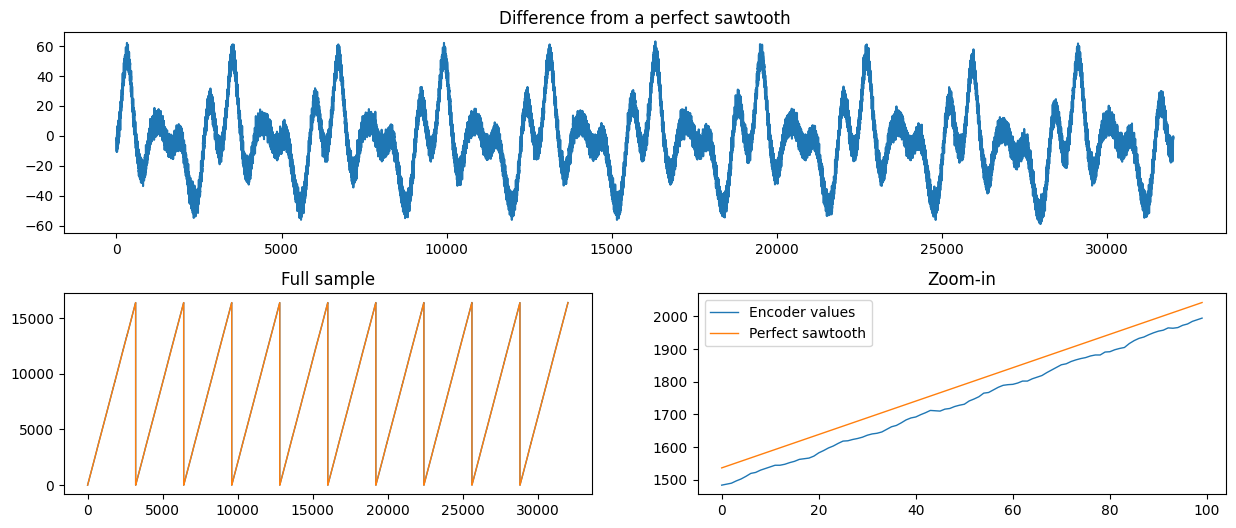

In [3]:
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 2])

plot = fig.add_subplot(gs[0, :])
plot.plot(diff)
plot.set_title("Difference from a perfect sawtooth")

full_revolution = fig.add_subplot(gs[1, 0])
full_revolution.plot(data, linewidth=1, label="Encoder values")
full_revolution.plot(sawtooth, linewidth=1, label="Perfect sawtooth")
full_revolution.set_title("Full sample")

zoom = fig.add_subplot(gs[1, 1])
zoom.plot(data[300:400], linewidth=1, label="Encoder values")
zoom.plot(sawtooth[300:400], linewidth=1, label="Perfect sawtooth")
zoom.legend()
zoom.set_title("Zoom-in")

plt.subplots_adjust(hspace=0.3)
plt.show()

# Data Processing

We'll smooth the difference signal and calculate the DC offset

In [4]:
kernel_size = 30
kernel = np.ones(kernel_size) / kernel_size
cleaned = np.convolve(diff, kernel, mode="same")

dc_offset = cleaned.mean()
centered = cleaned - dc_offset

DC Offset: -2.355828624674479


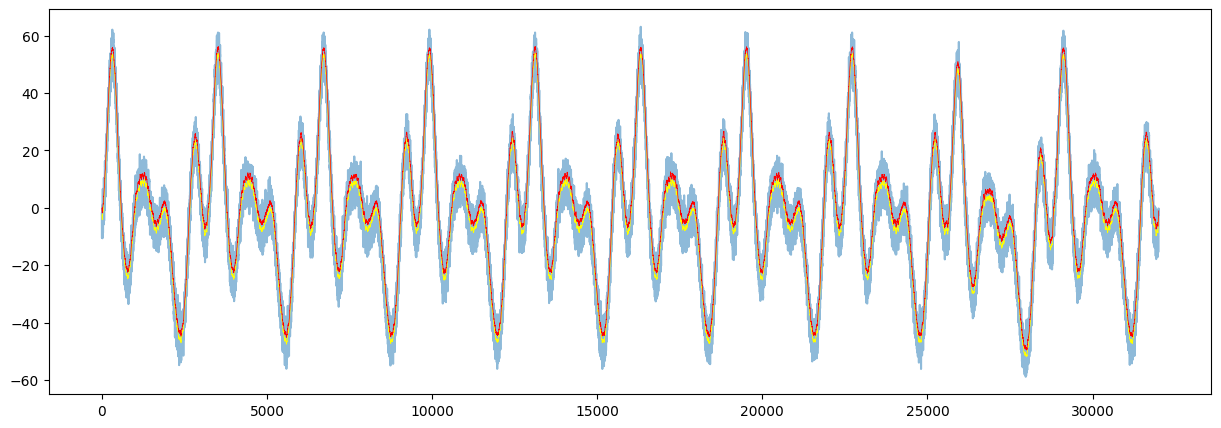

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(diff, alpha=0.5)
plt.plot(cleaned, color="yellow", linewidth=0.5)
plt.plot(centered, color="red", linewidth=0.5)
print(f"DC Offset: {dc_offset}")
plt.show()

## Fourier Analysis

Using Fourier Analysis, we fit a function to the difference signal.

In [6]:
period = 3200
sampling_rate = 1
n = len(centered)  # Number of samples
coefficients = np.fft.rfft(centered) / n
time_series = np.arange(0, period, sampling_rate)
frequencies = np.fft.rfftfreq(n, d=time_series[1] - time_series[0])

Freq:	0.0003125	Period:	3200.000


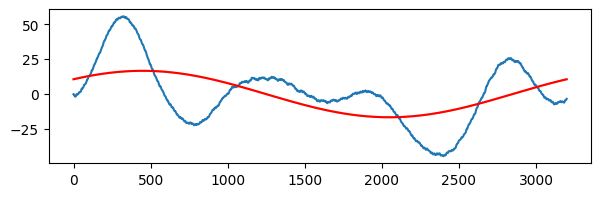

Freq:	0.000625	Period:	1600.000


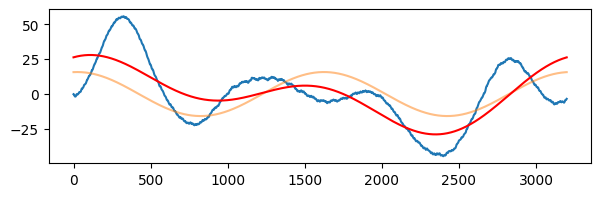

Freq:	0.0009375	Period:	1066.667


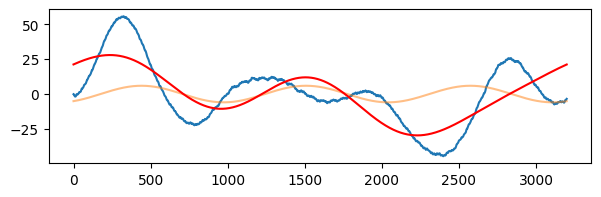

Freq:	0.00125	Period:	800.000


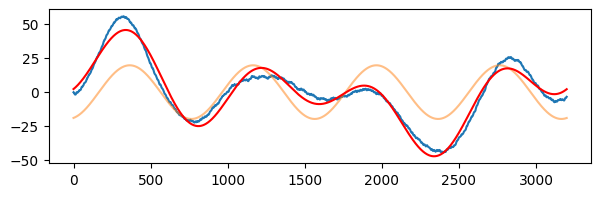

Freq:	0.0015625	Period:	640.000


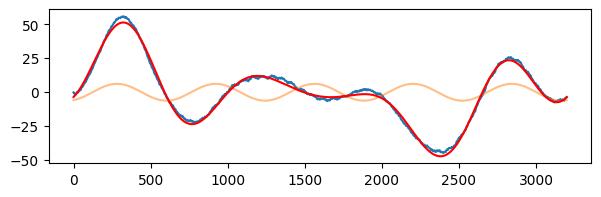

Freq:	0.001875	Period:	533.333


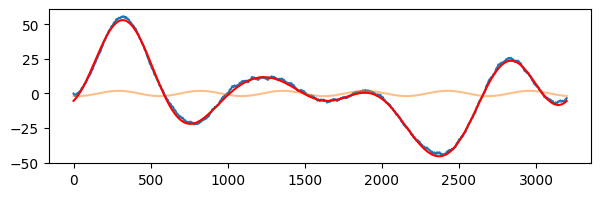

In [7]:
MIN_AMP = 0.5
MIN_FREQ = 1 / (period + 10)

filtered_f = []
filtered_c = []
fitted_func = np.zeros_like(time_series).astype(np.complex128)


for i in range(int(n / 2)):
    if frequencies[i] > MIN_FREQ and np.abs(coefficients[i]) > MIN_AMP:
        filtered_c.append(coefficients[i])
        filtered_f.append(frequencies[i])

        current = 2 * coefficients[i] * np.exp(2j * np.pi * frequencies[i] * time_series)

        fitted_func += current

        plt.figure(figsize=(7, 2))
        plt.plot(centered[:3200], label="Original signal")
        plt.plot(current.real, alpha=0.5, label="Added component")
        plt.plot(fitted_func.real[:3200], color="red", label="Fourier function")
        print(f"Freq:\t{frequencies[i]}\tPeriod:\t{1/frequencies[i]:.3f}")
        plt.show()

fitted_func += dc_offset

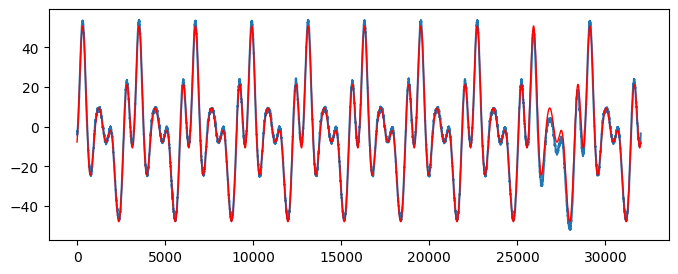

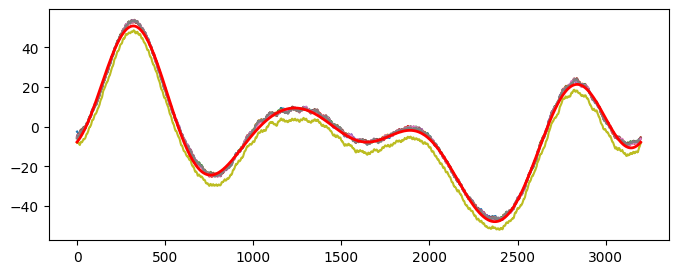

In [8]:
plt.figure(figsize=(8, 3))

plt.plot(cleaned)
plt.plot([*fitted_func.real] * 10, color="red", linewidth=1)
plt.show()
plt.figure(figsize=(8, 3))

for i in range(9):
    plt.plot(cleaned[i * 3200 : (i + 1) * 3200])
    
plt.plot(fitted_func.real, color="red", linewidth=2)

plt.show()

Freq	 Amp
312.5 	 8.346
625.0 	 7.908
937.5 	 2.979
1250.0 	 9.888
1562.5 	 3.092
1875.0 	 0.954


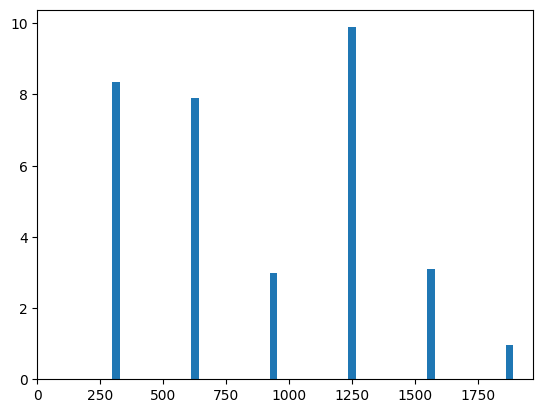

In [9]:
print("Freq\t Amp")
filtered_f_mhz = [i * 1000000 for i in filtered_f]
for i, j in zip(filtered_f_mhz, filtered_c):
    print(round(i, 3), "\t", round(np.abs(j), 3))

plt.bar(filtered_f_mhz, np.abs(filtered_c), width=30)
plt.xlim(0)
plt.show()

# Signal correction

Now we can use the Fourier function to calculate back the deviation between the encoder reading and the motor position

In [10]:
df["fitted_func"] = [*fitted_func.real] * 10
df["corrected_signal"] = df.fitted_func + df.data
df["corrected_sawtooth"] = df.sawtooth - df.fitted_func

df.head()

,sawtooth,data,point,fitted_func,corrected_signal,corrected_sawtooth
0,0.000000,2,56,-7.693521,-5.693521,7.693521
1,5.119688,11,57,-7.585466,3.414534,12.705154
2,10.239375,19,58,-7.475540,11.524460,17.714915
3,15.359063,24,59,-7.363747,16.636253,22.722809
4,20.478750,31,60,-7.250092,23.749908,27.728842


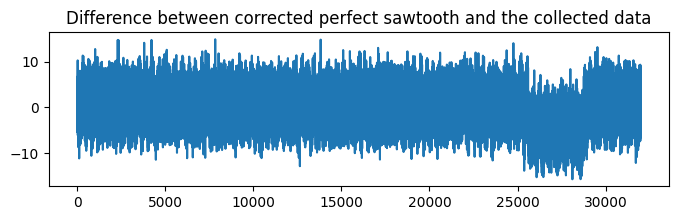

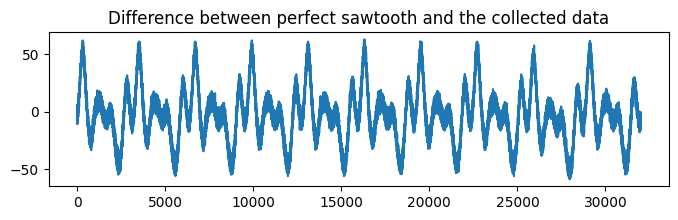

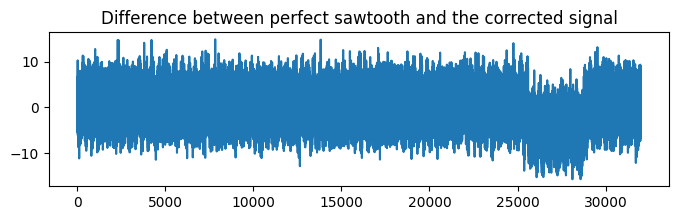

In [11]:
plt.figure(figsize=(8, 2))
plt.plot(df.corrected_sawtooth - df.data)
plt.title("Difference between corrected perfect sawtooth and the collected data")
plt.show()
plt.figure(figsize=(8, 2))
plt.plot(df.sawtooth - df.data)
plt.title("Difference between perfect sawtooth and the collected data")
plt.show()
plt.figure(figsize=(8, 2))
plt.plot(df.sawtooth - df.corrected_signal)
plt.title("Difference between perfect sawtooth and the corrected signal")
plt.show()

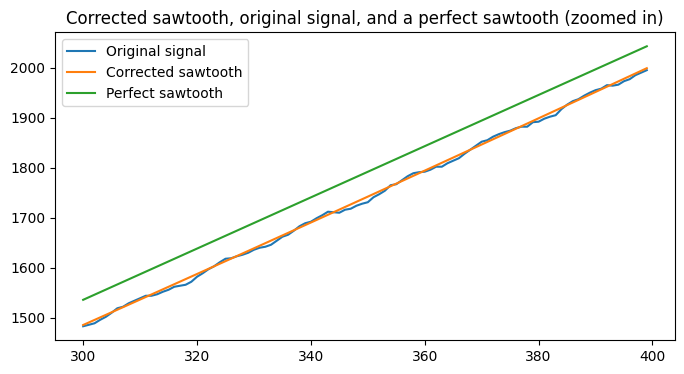

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(df.data[300:400], label="Original signal")
plt.plot(df.corrected_sawtooth[300:400], label="Corrected sawtooth")
plt.plot(df.sawtooth[300:400], label="Perfect sawtooth")
plt.title("Corrected sawtooth, original signal, and a perfect sawtooth (zoomed in)")
plt.legend()
plt.show()

# Create the lookup table

In [13]:
x = (np.linspace(0, 16384, 3200) - fitted_func[::-1].real).tolist()

def get_closest_index(lst, val):
    closest_val = min(lst, key=lambda x: abs(x - val))
    return lst.index(closest_val)

LUT = [get_closest_index(x, val) for val in range(16384)]

print(f"{str(LUT[:20])[:-1]} ... {str(LUT[-5:])[1:]}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2 ... 3197, 3197, 3197, 3197, 3197]


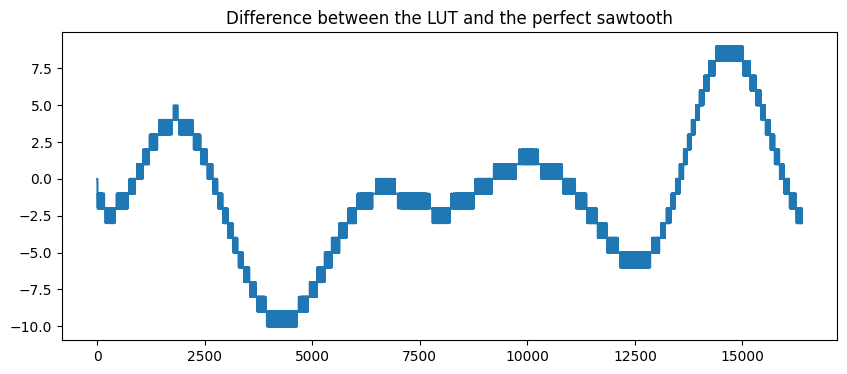

In [14]:
plt.figure(figsize=(10, 4))
plt.plot([i - j for i, j in zip(LUT, np.linspace(0, 3200, 16384).round())])
plt.title("Difference between the LUT and the perfect sawtooth")
plt.show()